In [1]:
library(tidyverse)
library(rsample)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Introduction

A computer science research group at UBC created a replica Minecraft server named Plaicraft, with the goal of collecting data that evaluates how people play video games. All players were volunteers. The researchers were able to collect data for each player that identified various characteristics such as their age, gender expression, and level of previous Minecraft experience, and they then tied that (using an anonymous id) to the number of cumulative hours each player had spent playing Plaicraft at the time of data collection. This project intends to determine whether certain demographics of age and experience level are more likely to contribute a large amount of data, and furthermore whether a satisfactory model can be created to predict the number of hours played (response variable) a certain player will contribute based on these two variables. We believe that this sort of predictive model will benefit researchers when trying to recruit active participants to the Plaicraft server.

In order to achieve this goal, we have decided to use the “players.csv” dataset (196 rows, 9 columns). This datatable appears tidy, as each row represents the data for one player, and each column represents a different variable. The nine different variables included are:

`experience` (type: character)
Players' self-reported level of Minecraft experience at the time of registering (categorical values, e.g. "Veteran").

`age` (type: double)
Players self-reported age (numerical value).

`subscribe` (type: logical) 
Whether or not users have agreed to subscribe to email notifications regarding server activity at the time of registering (two possible values: TRUE or FALSE).

`hashedEmail` (type: character)
Players' emails are encrypted to identify them anomalously within the dataset.

`played_hours` (type: double)
Cumulative number of hours a player has played at the time of data collection (numerical variable).

`name` (type: character)
Players' chosen pseudonym.

`gender` (type: character)
Players self-reported gender (categorical values, e.g. "Female")

`individualId` (type: logical) 
Empty (no data).

`organizationName` (type: logical) 
Empty (no data).

We are only interested in the first two variables listed: experience and age. This is because we later intend to use a knn regression-line model and thus require our explanatory variables to be numerical. Age is already a numerical variable, and level of experience is one of the only other variables that can reasonably be converted to a numerical variable (it can be treated as a scale, whereas other variables like gender cannot be interpreted as an objective scale). We did not want to include variables such as "subscribe", that occur upon registration and therefore cannot be used to inform recruitment decisions. Thus, our first step to wrangle our data was to select only for player_hours, experience, and age. And to convert experience to double value.

### Wrangling Data

In [2]:
library(tidyverse)
library(tidymodels)


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.



In [3]:
#load in data
googleplayers <- 'https://drive.google.com/file/d/1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz/edit'

#Turn google drive link into a direct link to load in the data
direct_link_players <- 'https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz'

players <- read_csv(direct_link_players)

head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [4]:
players_tidy <- players |> 
mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")) |> 
       unclass()) |> 
select(experience, played_hours, age) 
head(players_tidy)

experience,played_hours,age
<int>,<dbl>,<dbl>
4,30.3,9
5,3.8,17
5,0.0,17
2,0.7,21
3,0.1,21
2,0.0,17


In [5]:
data_split <- initial_split(players_tidy, prop = .75, strata = played_hours) 
players_training <- training(data_split) 
players_testing <- testing(data_split) 

### Summary and Exploratory Visualization

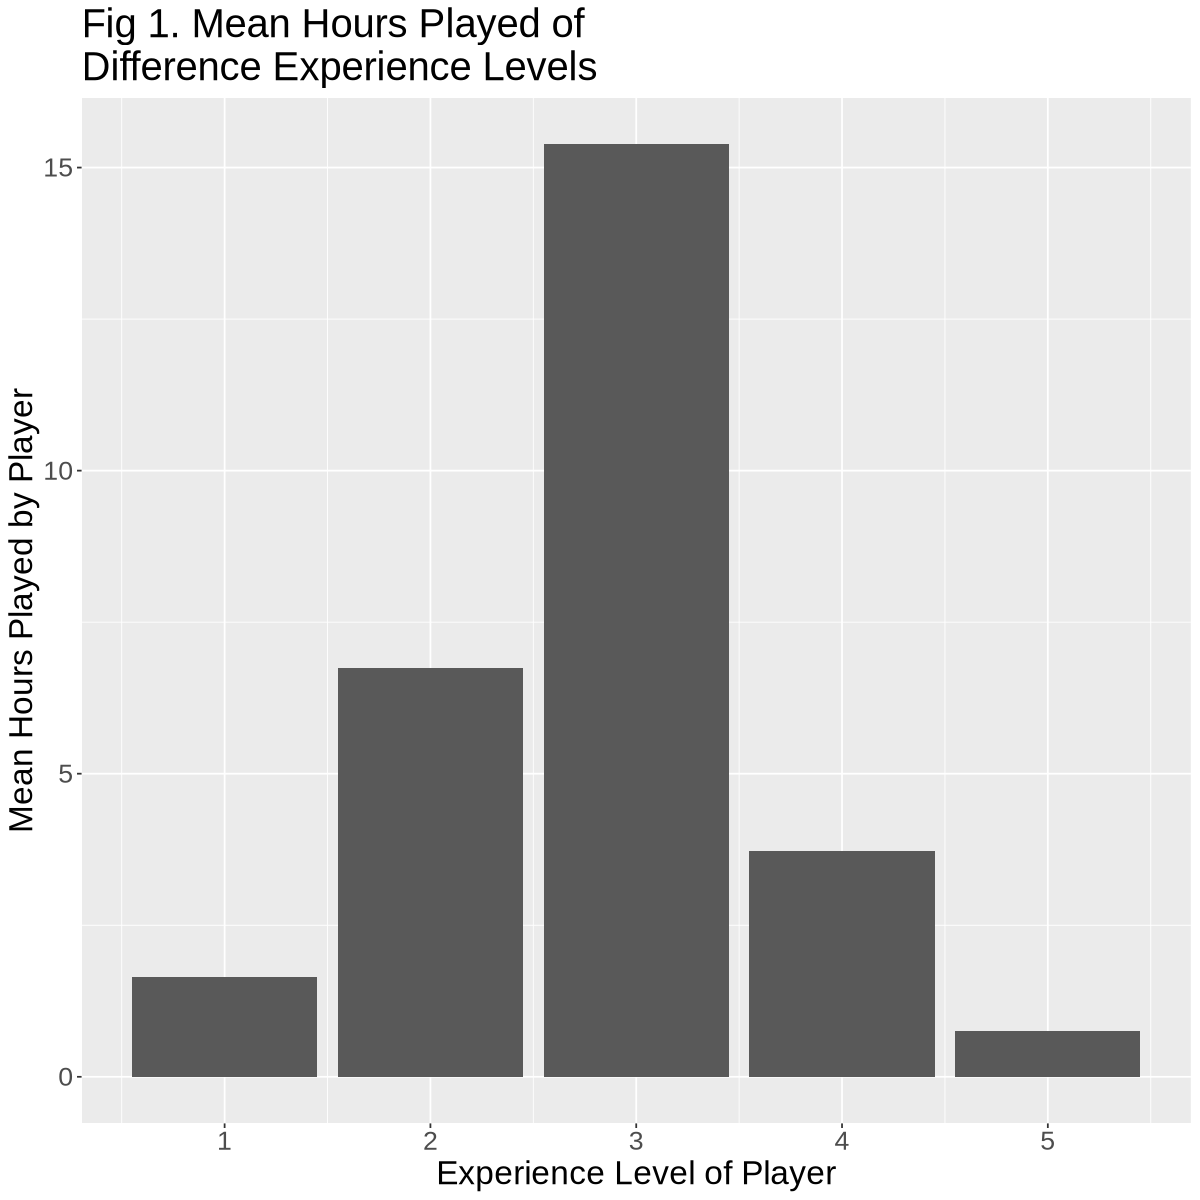

In [6]:
#graphing the amount of mean hours played by the different experience leveled players 
options(repr.plot.width = 10, repr.plot.height = 10) 

exp_hours_mean <- players_training|>
group_by(experience)|>
summarize(mean_exp = mean(played_hours))

players_h_vs_exp<- exp_hours_mean|>
                   ggplot(aes(x = experience, y = mean_exp))+
                   ggtitle("Fig 1. Mean Hours Played of \nDifference Experience Levels")+
                   geom_bar(stat = "identity")+
                   labs( x = "Experience Level of Player", y = "Mean Hours Played by Player") +
                   theme(text = element_text(size = 20))
players_h_vs_exp

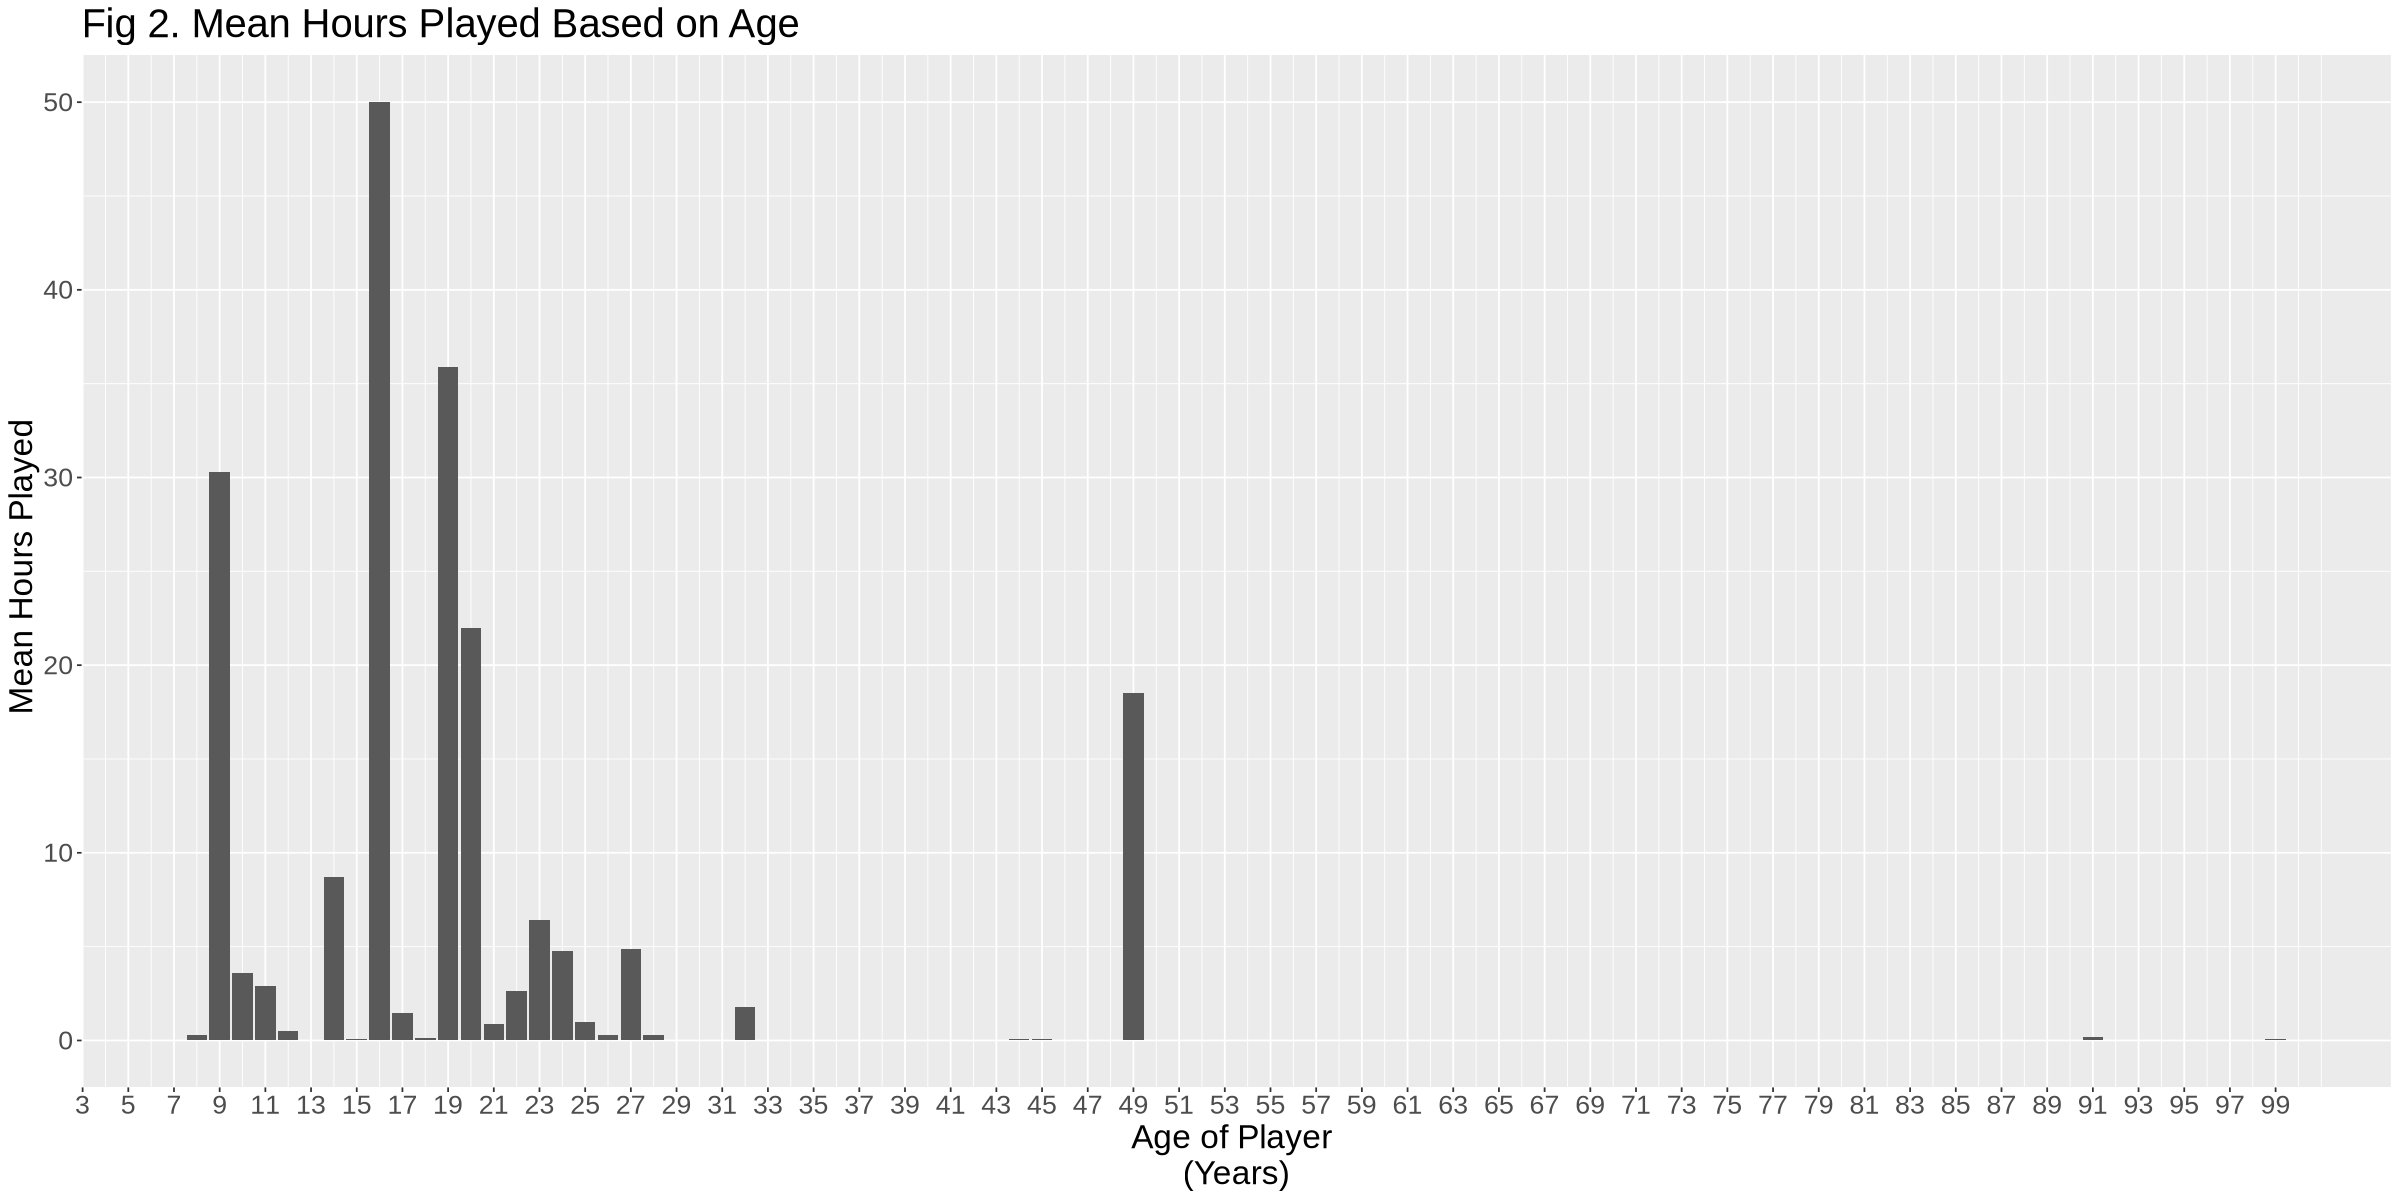

In [7]:
#graphing the amount of mean hours played by the different aged players 
options(repr.plot.width = 20, repr.plot.height = 10)

age_hours_mean <- players_training|>
group_by(age)|>
summarize(mean_age = mean(played_hours))
players_h_vs_age<- age_hours_mean|>
                   ggplot(aes(x = age, y = mean_age))+
                   ggtitle("Fig 2. Mean Hours Played Based on Age")+
                   geom_bar(stat = "identity")+
                   labs( x = "Age of Player \n(Years)", y = " Mean Hours Played")+
                   theme(text = element_text(size = 20))+
                   scale_x_continuous(breaks = seq(1,100, by = 2)) 
players_h_vs_age

#graphing the amount of mean hours played by the different gendered players 

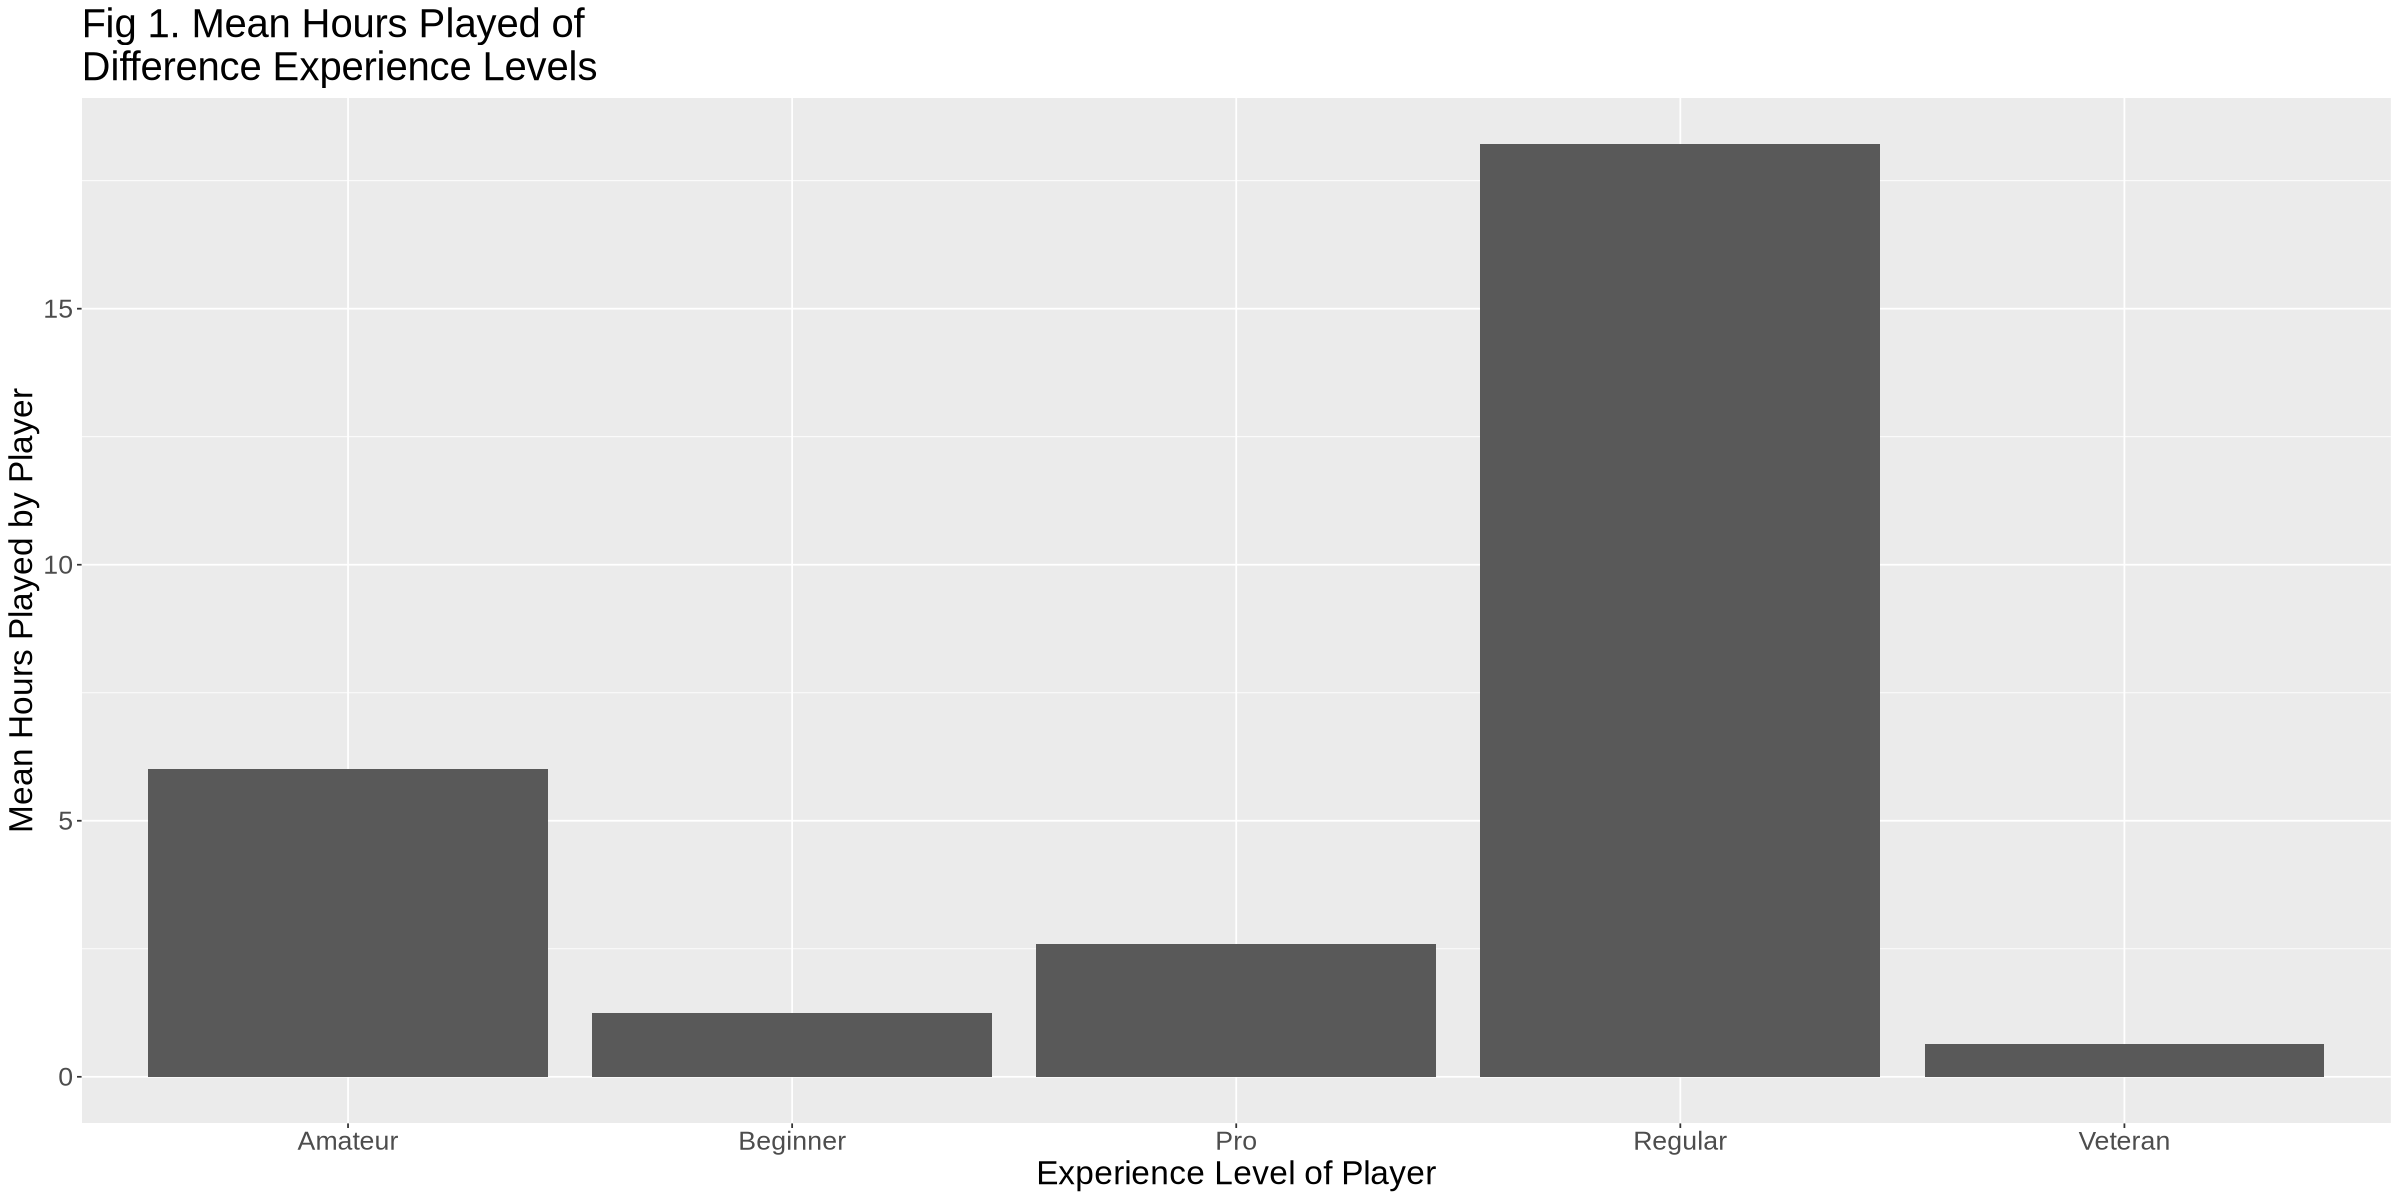

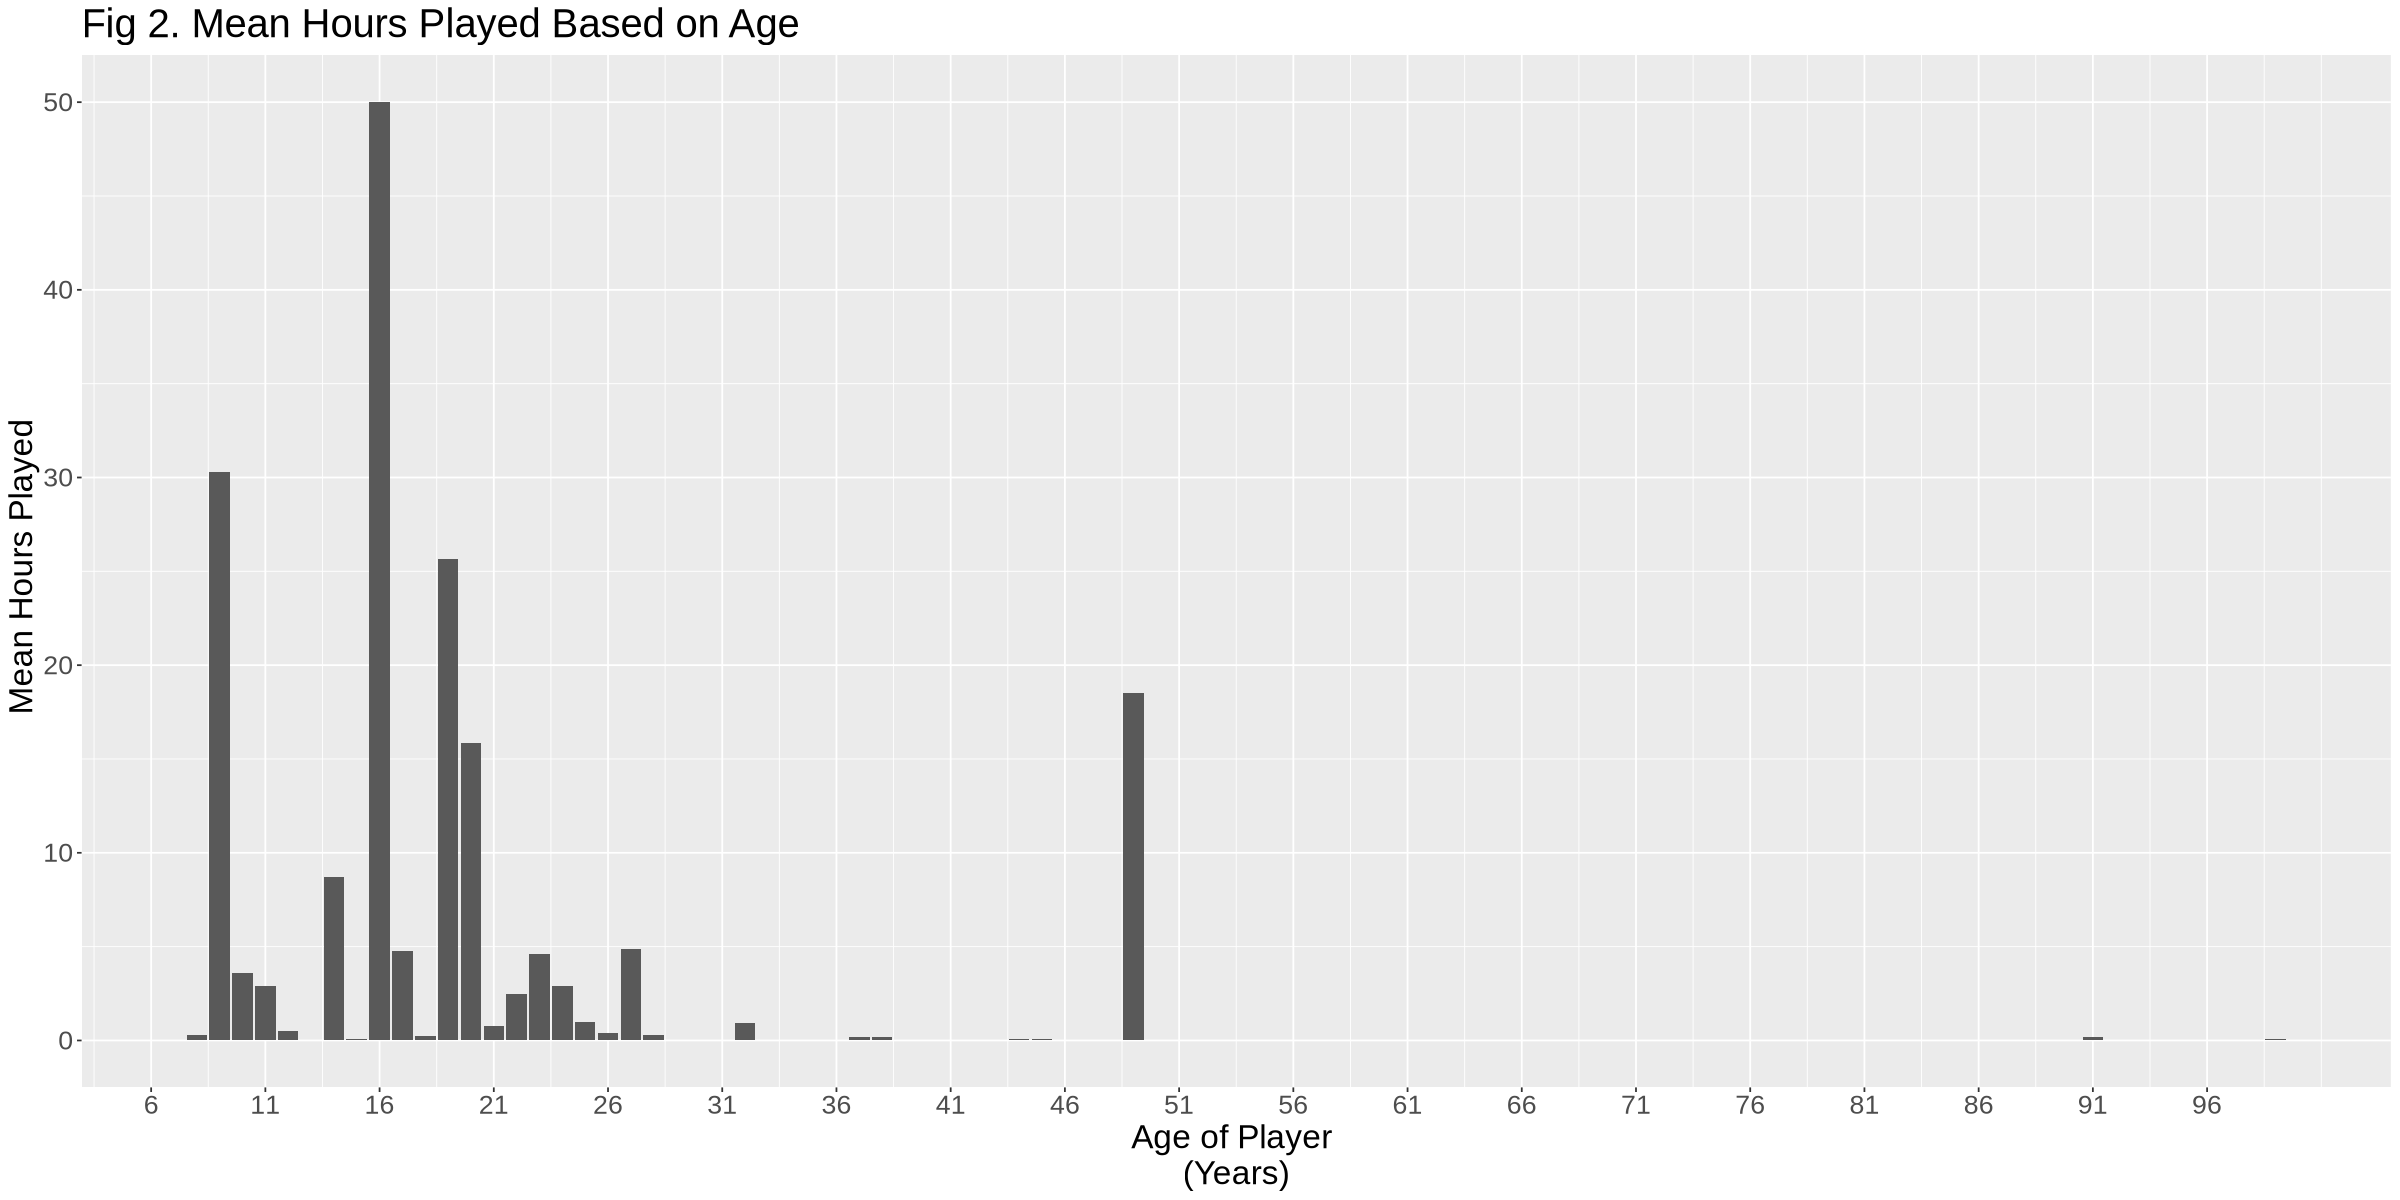

In [8]:
#graphing the amount of mean hours played by the different experience leveled players 
exp_hours_mean<-players|>
group_by(experience)|>
summarize(mean_exp = mean(played_hours))

players_h_vs_exp<- exp_hours_mean|>
                   ggplot(aes(x = experience, y = mean_exp))+
                   ggtitle("Fig 1. Mean Hours Played of \nDifference Experience Levels")+
                   geom_bar(stat = "identity")+
                   labs( x = "Experience Level of Player", y = "Mean Hours Played by Player") +
                   theme(text = element_text(size = 20))
players_h_vs_exp


#graphing the amount of mean hours played by the different aged players 

age_hours_mean<-players|>
group_by(age)|>
summarize(mean_age = mean(played_hours))

players_h_vs_age<- age_hours_mean|>
                   ggplot(aes(x = age, y = mean_age))+
                   ggtitle("Fig 2. Mean Hours Played Based on Age")+
                   geom_bar(stat = "identity")+
                   labs( x = "Age of Player \n(Years)", y = " Mean Hours Played")+
                   theme(text = element_text(size = 20))+
                   scale_x_continuous(breaks = seq(1,100, by = 5)) 
players_h_vs_age

#graphing the amount of mean hours played by the different gendered players 


### Data Analysis

### KNN-REGRESSION CODE W/ EXPERIENCE AS PREDICTOR


In [19]:
# KNN-REGRESSION MODEL
players_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune())|>
    set_engine('kknn')|>
    set_mode('regression')

# CROSS VALIDATION
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)
k_values <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

#RECIPE
experience_recipe <- recipe(played_hours ~ experience, data = players_training) |> 
step_scale(all_predictors()) |> 
step_center(all_predictors())

# WORKFLOW

experience_knn_workflow <- workflow() |>
    add_model(players_spec)|>
    add_recipe(experience_recipe)

experience_tuning <- experience_knn_workflow |>
    tune_grid(resamples = players_vfold, grid = k_values)|>
    collect_metrics()

best_experience_k <- experience_tuning |>
    filter(.metric == 'rmse')|>
    slice_min(mean, n = 1) 

# The result for tuning for the best K was when K = 4 with an RMSE of 19.23443
# The data is skewed in a lot of ways--need to talk about this

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x1



